In [1]:
import pandas as pd
from sklearn.cross_validation import train_test_split
import math
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# tsv to Dataframe
df_train = pd.read_csv('../data/raw/train.tsv',sep='\t')
df_test = pd.read_csv('../data/raw/test.tsv',sep='\t')

In [3]:
# Feature engineering from datetime
# https://adtech.cyberagent.io/techblog/archives/259
# https://note.nkmk.me/python-pandas-datetime-timestamp/
def create_date_future(df):
    df['datetime'] = pd.to_datetime(df['datetime']) # dtypeをdatetime64に変換
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek  

In [4]:
create_date_future(df_train)
create_date_future(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3
2,2015-01-01,日光国立公園,29714,2015,1,1,3
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3


In [5]:
# label encoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

def onehot_encdr_park(df):
    le = preprocessing.LabelEncoder()
    le.fit(df['park'])
    le.transform(['阿寒摩周国立公園', '十和田八幡平国立公園', '日光国立公園', '伊勢志摩国立公園','大山隠岐国立公園','阿蘇くじゅう国立公園', '霧島錦江湾国立公園', '慶良間諸島国立公園']) 
    
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['park'])
    df_park = pd.DataFrame(park_onehot,columns=le.classes_)
    df = pd.concat([df,df_park],axis=1)
    return df

In [6]:
df_train = onehot_encdr_park(df_train)
df_test = onehot_encdr_park(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,0,0,1,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,0,0,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,0,0,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,0,0,0,0,0


In [7]:
def onehot_encdr_dayofweek(df):
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['dayofweek'])
    df_park = pd.DataFrame(park_onehot,columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    df = pd.concat([df,df_park],axis=1)
    return df

In [8]:
df_train = onehot_encdr_dayofweek(df_train)
df_test = onehot_encdr_dayofweek(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,0,0,1,0,0,0


### データから特徴量作成

In [9]:
# holiday data include Saturday, Sunday
df_holiday = pd.read_csv('../data/raw/holiday.csv')
df_holiday['datetime'] = pd.to_datetime(df_holiday['datetime'])

In [10]:
# holiday data exclude Saturday, Sunday
df_holiday_exc_wkend = pd.read_csv('../data/raw/holiday.csv')
df_holiday_exc_wkend['datetime'] = pd.to_datetime(df_holiday_exc_wkend['datetime'])
df_holiday_exc_wkend['dayofweek'] = df_holiday_exc_wkend['datetime'].dt.dayofweek

# dayofweekが5 or 6(土曜or日曜)の場合、holidayカラムの値を0にする
df_holiday_exc_wkend.loc[(df_holiday_exc_wkend['dayofweek'] == 5) | (df_holiday_exc_wkend['dayofweek'] == 6), 'holiday'] = 0
df_holiday_exc_wkend = df_holiday_exc_wkend[['datetime','holiday']]
df_holiday_exc_wkend = df_holiday_exc_wkend.rename(columns={'holiday': 'pub_holiday'})
df_holiday_exc_wkend.head()

,datetime,pub_holiday
0,2015-01-01,1
1,2015-01-02,0
2,2015-01-03,0
3,2015-01-04,0
4,2015-01-05,0


In [11]:
# 防災科学技術研究所 ⼤⼭鏡ヶ成積雪気象観測施設における積雪気象観測データ
# 日ごとの積雪量の平均データを作成
df_nied_oyama = pd.read_csv('../data/raw/nied_oyama.tsv',sep='\t')
df_nied_oyama['日時'] = pd.to_datetime(df_nied_oyama['日時'])
df_nied_oyama['日時'] = df_nied_oyama['日時'].dt.strftime('%Y-%m-%d')
df_nied_oyama_mean = df_nied_oyama.groupby('日時',as_index=False).mean()[['日時','積雪深(cm)', '気温(℃)']]
df_oyama = df_nied_oyama_mean.assign(大山隠岐国立公園=1)
df_oyama = df_oyama.rename(columns={'日時': 'datetime'})
df_oyama.head()

,datetime,積雪深(cm),気温(℃),大山隠岐国立公園
0,2015-01-01,116.029167,-6.895833,1
1,2015-01-02,137.983333,-6.362500,1
2,2015-01-03,150.050000,-3.400000,1
3,2015-01-04,137.358333,0.166667,1
4,2015-01-05,126.766667,1.812500,1


# sin cos curve

In [12]:
N = 365 # データ数
N_ = 366
n = np.arange(365)
n_ = np.arange(366)

#  Not leap year
sin_cur_not_leap= np.sin(2*np.pi*n/N)
cos_cur_not_leap= np.cos(2*np.pi*n/N)

#  leap year
sin_cur_leap= np.sin(2*np.pi*n_/N_)
cos_cur_leap= np.cos(2*np.pi*n_/N_)

# concat for 2015, 2016
sin_cur = np.concatenate((sin_cur_not_leap, sin_cur_leap), axis=0)
cos_cur = np.concatenate((cos_cur_not_leap, cos_cur_leap), axis=0)

# to dataframe
sin_columns = 'sin'
df_sin_cur_train = pd.DataFrame(data=sin_cur,dtype='float')
df_cos_cur_train = pd.DataFrame(data=cos_cur,dtype='float')

# concat for 2017
df_sin_cur_test = pd.DataFrame(data=sin_cur_not_leap,dtype='float')
df_cos_cur_test = pd.DataFrame(data=cos_cur_not_leap,dtype='float')

In [13]:
df_weather = pd.read_csv('../data/raw/weather.tsv',sep='\t')
df_weather.head()

,年月日,地点,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),10分間降水量の最大(mm),日照時間(時間),合計全天日射量(MJ/㎡),最深積雪(cm),...,最多風向(16方位),平均蒸気圧(hPa),平均現地気圧(hPa),平均湿度(%),平均海面気圧(hPa),最小相対湿度(%),最低海面気圧(hPa),平均雲量(10分比),天気概況(昼:06時~18時),天気概況(夜:18時~翌日06時)
0,2015/1/1,十和田,-1.9,0.3,-2.9,5.0,1.0,2.1,NaN,18.0,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015/1/2,十和田,-3.9,-1.1,-8.0,0.0,0.0,3.3,NaN,17.0,...,西北西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015/1/3,十和田,-4.0,-1.6,-8.9,2.0,0.5,1.4,NaN,21.0,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015/1/4,十和田,0.6,3.4,-1.6,0.0,0.0,2.6,NaN,19.0,...,南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015/1/5,十和田,0.8,5.4,-5.1,0.0,0.0,4.0,NaN,14.0,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_weather = pd.read_csv('../data/raw/weather.tsv',sep='\t')
df_weather['日時'] = pd.to_datetime(df_weather['年月日'])
df_weather_mean = df_weather.groupby('日時',as_index=False).mean()[['日時','積雪深(cm)', '気温(℃)']]

KeyError: "['積雪深(cm)' '気温(℃)'] not in index"

### 作成した特徴量と学習データの結合

In [22]:
# 学習データと休日データの結合
#df_merged = pd.merge(df_train,df_holiday,on='datetime') # 
df_merged = pd.merge(df_train,df_holiday_exc_wkend,on='datetime')
#df_merged =  pd.merge(df_merged,df_holiday_exc_wkend,on='datetime')

# 学習データと⼤⼭気象データの結合
#df_oyama['datetime'] = pd.to_datetime(df_oyama['datetime'])
#df_merged = pd.merge(df_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')

# 学習データとsin/cosカーブデータの結合
df_datetime_train = df_train[~df_train.duplicated(subset='datetime')]['datetime']
df_datetime_train = df_datetime_train.reset_index()
df_datetime_train = df_datetime_train['datetime']
df_sin_cos = pd.concat([df_datetime_train,df_sin_cur_train,df_cos_cur_train], axis=1)
df_sin_cos.columns = ['datetime', 'sin', 'cos']
df_merged = pd.merge(df_merged,df_sin_cos,on='datetime')
df_merged.head(100)

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,0,1,0,0,0,1,0.000000,1.000000
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,1,0,0,0,1,0.000000,1.000000
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,1,0,0,0,1,0.000000,1.000000
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,1,0,0,0,1,0.000000,1.000000
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,1,0,0,0,1,0.000000,1.000000
5,2015-01-01,阿蘇くじゅう国立公園,1369,2015,1,1,3,0,0,0,...,0,0,0,1,0,0,0,1,0.000000,1.000000
6,2015-01-01,霧島錦江湾国立公園,35352,2015,1,1,3,0,0,0,...,0,0,0,1,0,0,0,1,0.000000,1.000000
7,2015-01-01,慶良間諸島国立公園,151,2015,1,1,3,0,0,0,...,0,0,0,1,0,0,0,1,0.000000,1.000000
8,2015-01-02,阿寒摩周国立公園,11153,2015,1,2,4,0,0,0,...,0,0,0,0,1,0,0,0,0.017213,0.999852
9,2015-01-02,十和田八幡平国立公園,33795,2015,1,2,4,0,1,0,...,0,0,0,0,1,0,0,0,0.017213,0.999852


In [16]:
from sklearn.cross_validation import train_test_split
import math
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

In [17]:
df_except_y = df_merged.drop(['park','visitors','datetime'], axis=1)
X_train = df_except_y.as_matrix() 
y_train = df_merged['visitors'].as_matrix()
df_except_y.head()

,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,...,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos
0,2015,1,1,3,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0.0,1.0
1,2015,1,1,3,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
2,2015,1,1,3,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0.0,1.0
3,2015,1,1,3,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
4,2015,1,1,3,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0


### 作成した特徴量とテストデータの結合

In [41]:
# holidayデータとのマージ
#df_test_merged = pd.merge(df_test,df_holiday,on='datetime')
df_test_merged = pd.merge(df_test,df_holiday_exc_wkend,on='datetime')
#df_test_merged = pd.merge(df_test_merged,df_holiday_exc_wkend,on='datetime')
#df_test_merged = pd.merge(df_test_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')

# sin/cosカーブデータとのマージ
df_datetime_test = df_test[~df_test.duplicated(subset='datetime')]['datetime']
df_datetime_test = df_datetime_test.reset_index()
df_datetime_test = df_datetime_test['datetime']
df_sin_cos_test = pd.concat([df_datetime_test,df_sin_cur_test,df_cos_cur_test], axis=1)
df_sin_cos_test.columns = ['datetime', 'sin', 'cos']
df_test_merged = pd.merge(df_test_merged,df_sin_cos_test,on='datetime')
df_test_merged = df_test_merged.drop(['park','datetime','index'], axis=1)
df_test_merged = df_test_merged.fillna(0)
X_test = df_test_merged.as_matrix()
df_test_merged.head()

,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,...,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos
0,2017,1,1,6,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0.0,1.0
1,2017,1,1,6,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0.0,1.0
2,2017,1,1,6,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0.0,1.0
3,2017,1,1,6,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.0,1.0
4,2017,1,1,6,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0.0,1.0


### モデル作成

In [37]:
# parametar tuning
params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }

model = xgb.XGBRegressor()
cv = GridSearchCV(model,params,cv=10,n_jobs=-1)

In [38]:
# Cross Validation
from sklearn.model_selection import train_test_split
# train：validation = 3：１
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train, random_state=0)

### sns.distplot
- sns.distplot(x, kde=False, rug=False, bins=10) 
- kdeは密度近似関数の描画のオプション、binsはx軸の刻み目の指定
- [参考](https://seaborn.pydata.org/generated/seaborn.distplot.html)

In [ ]:
# normality check　for the target
import  seaborn  as  sns
import matplotlib.pyplot as plt
ex = sns.distplot(y_train_cv, kde=True, rug=True, bins=10)
plt.show()

In [ ]:
# log-transform the dependent variable for nomality
y_train_cv = np.log(y_train_cv)*1000000000
y_train_cv
#print(y_train_cv.dtype)
y_train_cv = y_train_cv.astype(np.int32)
y_train_cv
#y_train_cv = [int(n) for n in y_train_cv]

ex = sns.distplot(y_train_cv,bins=10)
plt.show()

In [39]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(y_train_cv, freq=90)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [40]:
# model
cv.fit(X_train_cv, y_train_cv)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [2, 3, 5, 10], 'subsample': [0.5, 0.8, 0.9, 1], 'colsample_bytree': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

### year	month	day	dayofweek	伊勢志摩国立公園	十和田八幡平国立公園	大山隠岐国立公園	慶良間諸島国立公園	日光国立公園	阿寒摩周国立公園	阿蘇くじゅう国立公園	霧島錦江湾国立公園	Mon	Tue	Wed	Thu	Fri	Sat	Sun	holiday
1836.9206383981718 提出結果 1752.0008202777778

提出結果 1797.541828388889

### 積雪深(cm)	気温(℃)を追加
1840.624022338361　提出結果 2066.395654791667

### sin cosカーブを追加
MAE：1675.2158289650397 提出結果 1815.2318495033333

In [42]:
# predict
y_test_pred = cv.predict(X_test_cv)

# 評価
from sklearn.metrics import mean_absolute_error
print('MAE：{0}'.format(mean_absolute_error(y_test_cv, y_test_pred)))

MAE：1675.2158289650397


In [43]:
# model
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [2, 3, 5, 10], 'subsample': [0.5, 0.8, 0.9, 1], 'colsample_bytree': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [44]:
# 
reg = xgb.XGBRegressor(**cv.best_params_)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [46]:
# 学習モデルの保存、読み込み
import pickle
pickle.dump(reg, open("../model/model_10.pkl", "wb"))
#reg = pickle.load(open("../model/model_10.pkl", "rb"))

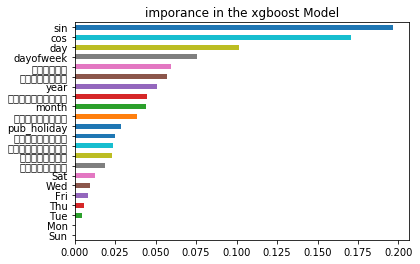

In [64]:
# future importance
import pandas as pd
import matplotlib.pyplot as plt
importances = pd.Series(reg.feature_importances_, index = df_except_y.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

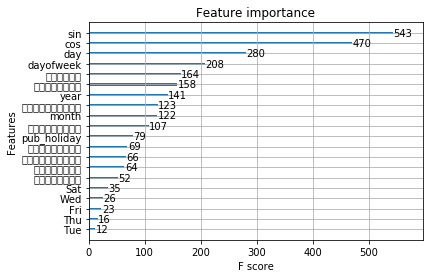

In [48]:
features =df_except_y.columns[df_except_y.any()]
mapper = {'f{0}'.format(i): v for i, v in enumerate(features)}
mapped = {mapper[k]: v for k, v in reg._Booster.get_fscore().items()}
xgb.plot_importance(mapped)

In [49]:
# predict
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [59]:
# create submit file
df_submit = pd.DataFrame({
    '':df_test['index'],
    '':y_test_pred})
# pandas.[DataFrame or Series].where(cond,other=xxx) condがFalseの時にotherを代入
# マイナスと予測した結果を０に修正
df_submit = df_submit.where(df_submit.iloc[:, [0]] > 0, 0)
df_submit.drop(0) # delete first line fue to NaN 
df_submit.head()

,
0,10385.134766
1,18079.427734
2,32408.742188
3,46405.011719
4,747.756653


In [63]:
df_submit.to_csv('../submit/submit_10.tsv',sep='\t',header=None)